# EEE 197z Project 1 - Zero Shot Object Detection
use SAM to perform zero-shot object detection using COCO 2017 val split. 

*Author: Sean Red Mendoza | 2020-01751 | scmendoza5@up.edu.ph*

## Tools/ References
- [SegmentAnything](https://github.com/facebookresearch/segment-anything)
- [OpenClip](https://github.com/mlfoundations/open_clip)
- [Coco 2017 Validation Dataset](https://cocodataset.org/#home)
- [roatienza/mlops](https://github.com/roatienza/mlops)
- [roatienza/Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments)
- [Google Cloud G2 GPU VM (Nvidia L4)](https://cloud.google.com/blog/products/compute/introducing-g2-vms-with-nvidia-l4-gpus)

## Goals

## Approach

## Notes


In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import torch
import torchvision
from skimage import io
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os
import open_clip
from PIL import Image
from pprint import pprint
import json
import shutil
import re
import urllib

import cv2
import urllib.request
import validators
from pytriton.client import ModelClient

import csv

In [2]:

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
print("[setup]: determining CUDA support...")
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

[setup]: determining CUDA support...
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True


In [3]:
# clean output directory
if not os.path.exists("../output"):
    os.mkdir(f"../output")
shutil.rmtree("../output/")
os.mkdir(f"../output/")

## Images
This program supports manual entry of input image links or random sampling from the CoCo 2017 Validation Dataset
*Please select your desired input method below:*

- [1] Input Images
- [2] CoCo Images

After selecting the input image source, you will be asked to input the following:
- [a] List of image URL strings, or
- [b] number of random images sourced from CoCo 2017*

**a hard limit of 10 images is set to prevent overloading of the system*

In [4]:
def get_valid_input():
    while True:
        user_input = input("Enter 1 or 2: ")
        if user_input in ['1', '2']:
            return int(user_input)
        else:
            print("Invalid input. Please enter 1 or 2.")
            
def get_valid_number(n):
    while True:
        user_input = input("Enter an integer from 1 to {}: ".format(n))
        if user_input.isdigit():
            number = int(user_input)
            if 1 <= number <= n:
                return number
        print("Invalid input. Please enter an integer from 1 to {}.".format(n))

# input_type = get_valid_input()
input_type = 2

if input_type == 1:
    input_mode = "manual"
    print("You have selected MANUAL_INPUT, please enter the image URLs in the following block")
elif input_type==2:
    input_mode = "random"
    # input_image_count = get_valid_number(10)
    input_image_count = 1
    print(f"You have selected RANDOM_INPUT of {input_image_count} images from the CoCo 2017 dataset")

You have selected RANDOM_INPUT of 1 images from the CoCo 2017 dataset


In [5]:

print("[0]: loading coco annotations and captions...")
dataDir = '../coco'
dataType = 'val2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir, dataType)

if not os.path.isfile(annFile):
    print("please download the coco val2017 instances dataset!")
    print("http://images.cocodataset.org/annotations/annotations_trainval2017.zip")
    quit()

# initialize COCO api for instance annotations + COCO ground truth api
cocoGt = COCO(annFile)
annFile = '{}/annotations/captions_{}.json'.format(dataDir, dataType)
coco_caps = COCO(annFile)
catIDs = cocoGt.getCatIds()
cats = cocoGt.loadCats(catIDs)
cocoCategories = [cat['name'] for cat in cats]


[0]: loading coco annotations and captions...
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [6]:
input_image_IDs = []
input_image_catIDs = []
input_images_links = []
input_image_areas = []
input_image_labels = []

## RANDOM INPUT
def get_random_coco_image(n):
    for i in range(n):
        # get random coco image
        catID = catIDs[np.random.randint(0, len(catIDs))]
        catImages = cocoGt.getImgIds(catIds=[catID])
        imgID = catImages[np.random.randint(0, len(catImages))]
        # build image meta data
        img = cocoGt.loadImgs(imgID)[0]
        imgArea = img['height']*img['width']
        imgURL = img['coco_url']
        # fetch ground truth labels from coco
        annIds = coco_caps.getAnnIds(imgIds=imgID)
        anns = coco_caps.loadAnns(annIds)
        ground_truth_labels = list(map(lambda x: x['caption'], anns))
        input_image_IDs.append(imgID)
        input_image_catIDs.append(catID)
        input_images_links.append(imgURL)
        input_image_areas.append(imgArea)
        input_image_labels.append(ground_truth_labels)

if input_type == 2:
    random_images = get_random_coco_image(input_image_count)    

## MODIFY FOR MANUAL INPUT
if input_type == 1:
    # input_images_links = ['../images/dog_car.jpg']
    input_images_links = ['https://djl.ai/examples/src/test/resources/dog_bike_car.jpg']

In [7]:
coco_results = []
label_results = []
top_one_scores = []
top_five_scores = []

In [8]:
print("[1]: loading sam model")
sam_checkpoint = os.path.join("../checkpoints", "sam_vit_h_4b8939.pth")

# Download the file if it does not exist
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
if not os.path.isfile(sam_checkpoint):
    urllib.request.urlretrieve(url, sam_checkpoint)

model_type = "vit_h"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch=128,
    pred_iou_thresh=0.6,
    box_nms_thresh=0.1, # prevent overlapping of masks
    stability_score_thresh=0.3, # allow masks to cover "entire objects"
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
)

[1]: loading sam model


In [9]:
print("[2]: creating open clip model...")
modelType = 'ViT-B-16'
modelDataset = "laion2b_s34b_b88k"
model, _, preprocess = open_clip.create_model_and_transforms(
    modelType, pretrained=modelDataset)
tokenizer = open_clip.get_tokenizer(modelType)

model = model.to(device)



[2]: creating open clip model...


In [10]:
model_labels = []


# use coco categories as labels
model_labels.extend(cocoCategories)


# use coco validation labels

# get all captions
# annIds = coco_caps.getAnnIds(imgIds=[], catIds=[])
# anns = coco_caps.loadAnns(annIds)
# coco_labels_words = []
# for ann in anns:
#     words = ann['caption'].split()
#     for word in words:
#         clean_word = re.sub(r'[^a-zA-Z0-9\s]', '', word.lower())
#         coco_labels_words.append(clean_word)

# coco_labels_words_values = list(set(coco_labels_words))
# model_labels.extend(coco_labels_words_values)

# USE IMAGE NET LABELS

# filename = "../labels/imagenet1000_labels.txt"
# url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"

# # Download the file if it does not exist
# if not os.path.isfile(filename):
#     urllib.request.urlretrieve(url, filename)

# with open(filename) as f:
#     idx2label = eval(f.read())

# raw_imagenet_labels = list(idx2label.values())
# imagenet_labels = []
# for imagenet_label in raw_imagenet_labels:
#     args = imagenet_label.split(",")
#     if len(args)>=2:
#         for arg in args:
#             imagenet_labels.append(arg.lower().strip())
#     else: 
#         imagenet_labels.append(imagenet_label.lower().strip())
        
# text = tokenizer(imagenet_labels)
# text = text.to(device)
# model_labels = imagenet_labels

# use SIMPLE IMAGENET LABELS

filename = "../labels/imagenet-simple-labels.json"
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# Download the file if it does not exist
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)

with open(filename) as f:
    raw_imagenet_labels = eval(f.read())
imagenet_labels = []
for imagenet_label in raw_imagenet_labels:
    imagenet_labels.append(imagenet_label.lower().strip())
    
model_labels.extend(imagenet_labels)


# use Open Images Classes Dataset 
# from https://storage.googleapis.com/openimages/2017_11/classes_2017_11.tar.gz

filter_filename = "../labels/classes-bbox.txt"  
with open(filter_filename, "r") as file:
    lines = file.readlines()  
filter_classes = [line.strip() for line in lines]
labels_filename = '../labels/openimages-classes-raw.csv'
openimage_data = []
with open(labels_filename, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if (row[0] in filter_classes):
            openimage_data.append(row[1])

column_index = 1  
openimage_labels = [word.lower().strip() for word in openimage_data]
model_labels.extend(openimage_labels)

# PROCESS LABELS
model_labels = list(set(model_labels)) # remove duplicates
print(model_labels)
text = tokenizer(model_labels)
text = text.to(device)

['envelope', 'toy', 'pressure cooker', 'bowl', 'jacket', 'bath towel', 'white-headed capuchin', 'american lobster', 'yorkshire terrier', 'sea slug', 'border terrier', 'indigo bunting', 'tiger cat', 'bloodhound', 'plate', 'bicycle wheel', 'grasshopper', 'stupa', 'eggnog', 'bow', 'monastery', 'sleeping bag', 'electric fan', 'hair', 'crt screen', 'match', 'parking meter', 'mechanical fan', 'minivan', 'kingsnake', 'sweatshirt', 'countertop', 'passenger car', 'granny smith', 'partridge', 'train', 'butternut squash', 'african rock python', 'snowmobile', 'electric locomotive', 'wallaby', 'remote', 'power drill', 'impala', 'swan', 'mitten', 'grand piano', 'skunk', 'boathouse', 'taco', 'clogs', 'newt', 'winter melon', 'goat', 'carbonara', 'mosquito net', 'cucumber', 'griffon bruxellois', 'cornet', 'fur coat', 'crossword', 'ear', 'frying pan', 'cicada', 'rapeseed', 'red wine', 'mirror', 'barn', 'drilling rig', 'weapon', 'violin', 'canary', 'lawn mower', 'orangutan', 'fruit', 'african bush elepha

In [11]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))
        
def shows_masks_with_labels(anns, labels, probs):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for i in range(len(sorted_anns)):
        mask = sorted_anns[i]
        label = labels[i]
        prob = probs[i]
        if (prob > 0.25):
            x, y, w, h = mask['bbox']
            color = np.random.rand(3,)
            rect = plt.Rectangle((x, y), w, h, fill=False, color=color)
            ax.add_patch(rect)
            color = np.append(color, 0.5)
            ax.text(x, y, f"{label} {prob:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))


def filter_masks(raw_masks, area):
    if len(raw_masks) == 0:
        return
    length = len(raw_masks)
    sorted_anns = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    filtered_masks = []
    for i in range(length):
        mask = sorted_anns[i]
        if (mask['area'] < area):
            continue
        filtered_masks.append(mask)
    return filtered_masks


def save_mask_images(image, image_index, filtered_masks):
    if len(filtered_masks) == 0:
        return
    length = len(filtered_masks)
    sorted_anns = sorted(filtered_masks, key=(lambda x: x['area']), reverse=True)
    counter = 1
    filtered_masks = []
    for i in range(length):
        mask = sorted_anns[i]
        x, y, w, h = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        im = image[y:y+h, x:x+w]
        plt.figure(figsize=(20, 20))
        plt.imshow(im)
        plt.axis('off')
        plt.savefig(f"../output/{image_index}/mask-{counter}.jpg",
                    bbox_inches='tight', pad_inches=0)
        plt.close()
        counter += 1
        filtered_masks.append(mask)
    return filtered_masks

def generate_labels(anns, image_index):
    if len(anns) == 0:
        return
    length = len(anns)
    labels = []
    probs =  []
    for i in range(length):
        im = Image.open(f"../output/{image_index}/mask-{i+1}.jpg").convert("RGB")
        img = preprocess(im).unsqueeze(0)
        img = img.to(device)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(img)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_probs = (100.0 * image_features @
                          text_features.T).softmax(dim=-1)

        text_prob = np.max(text_probs.cpu().numpy())
        index = np.argmax(text_probs.cpu().numpy())
        label = model_labels[index]
        labels.append(label)
        probs.append(text_prob)
        # print(f"[{i+1}/{length}]:",  label, f"({text_prob*100:.2f}%)",)
        
    return labels, probs
        

def save_labels(anns, labels, probs, imgID, catID):
    if len(anns) == 0:
        return
    length = len(anns)
    values = []
    for i in range(length):
        mask = anns[i]
        label = labels[i]
        text_prob = probs[i]
        values.append(
            {"label": label, "area": mask["area"], "prob": text_prob})
        result = {'image_id': imgID, 'category_id': catID,
                  "bbox": mask['bbox'], "score": mask['predicted_iou']}
        coco_results.append(result)
    # generate top 5 labels according to label_accuracy and mask_area
    sorted_values = sorted(values, key=lambda x: x['prob'])
    payload = sorted_values[:5]
    labels = list(map(lambda d: d['label'], payload))
    return labels

def isTopNAccurate(substrings, string):
    isAccurate = False
    for substring in substrings:
        if substring in string:
            isAccurate = True
            break
    return isAccurate

In [12]:
url = "http://202.92.132.48:8000/"
# url = "http://localhost:8000"
def infer_model(url=url, image="../sam/images/dog_car.jpg", model="Yolov8x"):
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v
        
        # Plotting
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)
        ax.axis('off')
        for i in range(len(names)):
            if probs[i] > 0.5:
                x1, y1, x2, y2 = bboxes[i]
                w = x2 - x1
                h = y2 - y1
                # make the color random
                color = np.random.rand(3,)
                rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
                ax.add_patch(rect)
                # use the color and add transparency of 0.5
                color = np.append(color, 0.5)
                # add text with white background
                ax.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))
                
                
                

http://images.cocodataset.org/val2017/000000275198.jpg
(0): generated 228 masks...
(0): masks filtered down to 23 masks...


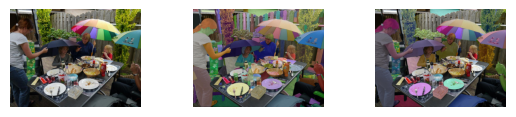

GENERATED LABELS
['accordion',
 'umbrella',
 'jeans',
 'cock',
 'tree',
 'plant',
 'umbrella',
 'umbrella',
 'wool',
 'umbrella',
 'potted plant',
 'food',
 'carbonara',
 'broccoli',
 'street light',
 'barrette',
 'consomme',
 'buckle',
 'thatched roof',
 'crate',
 'wool',
 'daisy',
 'whisk']


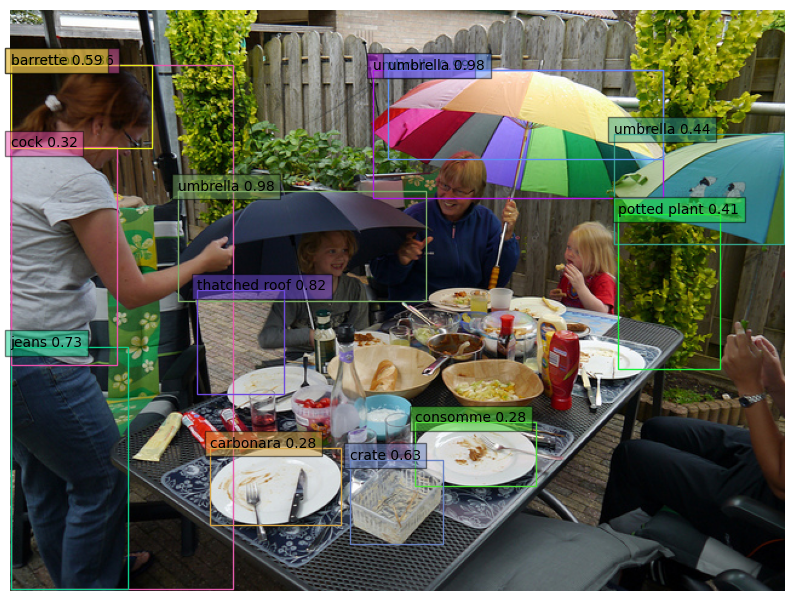

GROUND TRUTH LABELS
['A group of people holding umbrellas eating a meal outdoors.',
 'A woman standing next to a table covered with plates of mostly eaten food.',
 'A family holding umbrellas at a backyard barbecue.',
 'A family having lunch in their backyard in the rain.',
 'A group of people around a metal table with umbrellas.']


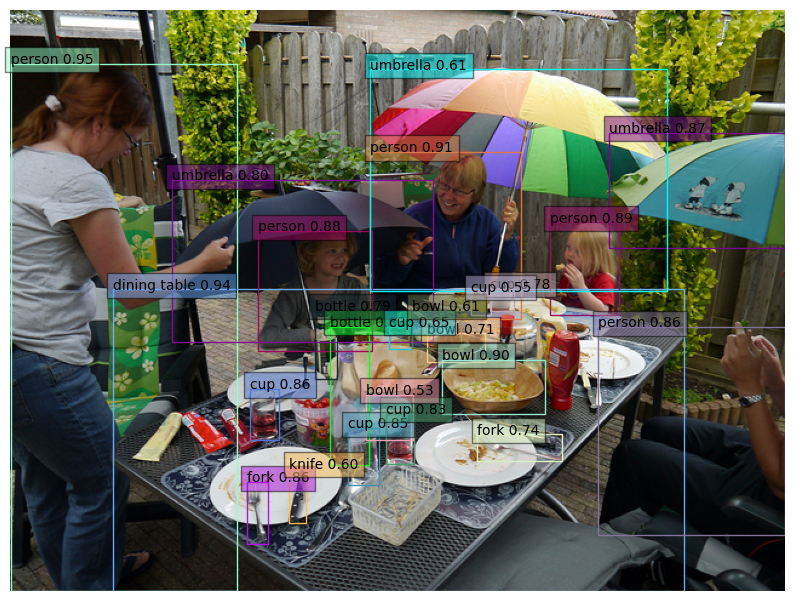

In [13]:
for image_index in range(len(input_images_links)):
    image_link = input_images_links[image_index]
    print(image_link)
    # create output folder for this image
    
    image_folder_path = f"../output/{image_index}"
    if not os.path.exists(image_folder_path):
        os.mkdir(image_folder_path)
    
    image = io.imread(image_link)
    height, width = image.shape[:2]
    imageArea = height * width
    maskArea = 0.01 * imageArea
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(f"../output/{image_index}/source.jpg",
                bbox_inches='tight', pad_inches=0)
    plt.close()
    
    raw_masks = mask_generator.generate(image)
    print(f"({image_index}): generated {len(raw_masks)} masks...")
    filtered_masks = filter_masks(raw_masks, maskArea)
    print(f"({image_index}): masks filtered down to {len(filtered_masks)} masks...")


    plt.figure(figsize=(20, 10))
    plt.imshow(image)
    show_anns(raw_masks)
    plt.axis('off')
    plt.savefig(f"../output/{image_index}/generated-raw-masks.jpg",
                bbox_inches='tight', pad_inches=0)
    plt.close()
    
    plt.figure(figsize=(30, 10))
    plt.imshow(image)
    show_anns(filtered_masks)
    plt.axis('off')
    plt.savefig(f"../output/{image_index}/generated-filtered-masks.jpg",
                bbox_inches='tight', pad_inches=0)
    plt.close()
    
    source_image = io.imread(f"../output/{image_index}/source.jpg")
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(source_image, cmap='gray')
    axs[0].axis('off')
    masked_image = io.imread(f"../output/{image_index}/generated-raw-masks.jpg")
    axs[1].imshow(masked_image, cmap='gray')
    axs[1].axis('off')
    masked_image = io.imread(f"../output/{image_index}/generated-filtered-masks.jpg")
    axs[2].imshow(masked_image, cmap='gray')
    axs[2].axis('off')
    plt.subplots_adjust(wspace=0.4)
    plt.show()
    plt.close()
    
    # save mask image files
    save_mask_images(image, image_index, filtered_masks)
    
    # print(f"({image_index}): generating labels...")
    generated_labels, generated_probs = generate_labels(filtered_masks, image_index)
    print("GENERATED LABELS")
    pprint(generated_labels)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    shows_masks_with_labels(filtered_masks, generated_labels, generated_probs)
    plt.axis('off')
    plt.savefig(f"../output/{image_index}/generated-masks-labels.jpg",
                bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    
    infer_model(image=image_link)
    
    if input_type == 2:
        image_id = input_image_IDs[image_index]
        image_category_id = input_image_catIDs[image_index]
        # print("image ID:", image_id, "category ID:", image_category_id)
        annIds = coco_caps.getAnnIds(imgIds=image_id)
        anns = coco_caps.loadAnns(annIds)
        ground_truth_labels = []
        ground_truth = []
        for ann in anns:
            ground_truth_labels.append(ann['caption'])
            words = ann['caption'].split()
            for word in words:
                ground_truth.append(word.lower())
        ground_truth_values = list(set(ground_truth))

        # for each mask image, annotate using open-clip
        save_labels(filtered_masks, generated_labels, generated_probs, image_id, image_category_id)
        print("GROUND TRUTH LABELS")
        pprint(ground_truth_labels)
        ground_truth_string = " ".join(ground_truth_labels)
        
        top_one_scores.append(generated_labels[0] in ground_truth_string)
        top_five_scores.append(isTopNAccurate(
            generated_labels, ground_truth_string))

In [14]:
if (input_type == 2):
    print("[4]: evaluating image results...")
    print("[4] mAPS SCORE")
    json_object = json.dumps(coco_results, indent=4)
    with open("../output/results.json", "w") as outfile:
        outfile.write(json_object)
    cocoDt = cocoGt.loadRes("../output/results.json")
    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
    cocoEval.params.imgIds = input_image_IDs
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("[4] Top-1 Accuracy SCORE")
    top_one_score = top_one_scores.count(True)/len(top_one_scores)
    print(top_one_score)
    print("[4] Top-5 Accuracy SCORE")
    top_five_score = top_five_scores.count(True)/len(top_five_scores)
    print(top_five_score)


[4]: evaluating image results...
[4] mAPS SCORE
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     